# NICER Timing Analysis: CTCV J2056-3014
### *To view plots, visit [nbviewer](https://nbviewer.org/github/ericymiao/ctcvj2056-timing-spin-evolution/blob/main/notebooks/01_nicer_timing.ipynb)*

Pulsation for 2021 and 2024 NICER observations + hardness ratio analysis

## NICER-Specific Notes

NICER (Neutron star Interior Composition Explorer) provides high time-resolution X-ray observations in the 0.2-12 keV band. Key considerations for this analysis:

- **Background estimation**: Unlike XMM-Newton or NuSTAR where background is extracted from source-free regions on the detector, NICER uses the **SCORPEON background model** which estimates background rates based on spacecraft pointing, space weather conditions, and detector state. While this estimated background isn't accurate enough for direct subtraction, it's useful for estimating a noise baseline after folding. 
    - Benefits: More accurate pulsed profiles (which agree with XMM and NuSTAR) and hardness ratios. 
    - Data: NICER has only one focal plane module, and no source/bkg region differentiation. So: Only one file per observation
- **Energy range**: We use 0.3-10 keV (or 0.3-7 keV for some observations) to avoid high noise and low and high energies. The maximum energy cutoff is determined as the energy when background flux, estimated by **SCORPEON**, exceeds source flux. 

In [38]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from scipy.signal import find_peaks
from stingray import EventList, Lightcurve
from stingray.pulse import z_n_search
from astropy.time import Time, TimeDelta
from astropy.timeseries import LombScargle
import hendrics.io as HENio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

from timing_analysis import *
from statistics import *

plt.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'figure.constrained_layout.use': True,
})

savedir = '../paper_figures'

## Load Data

- **Observation IDs**: NICER observations are split into 1 day segments, so observations ending in ``00`` are combined segments into one observation. 

In [26]:
# Load event files
events = {
    '4592010200': {'total':{}, 'soft':{}, 'hard':{}},
    '4592010300': {'total':{}, 'soft':{}, 'hard':{}},
    '4592010000': {'total':{}, 'soft':{}, 'hard':{}},
    '7656010100': {'total':{}, 'soft':{}, 'hard':{}},
}

data_path = '../../../analysis_files_strictfilter'

events['4592010200']['total'] = HENio.load_events(f'{data_path}/ni4592010200_0mpu7_cl_bary_nicer_xti_ev_calib.nc')
events['4592010300']['total'] = HENio.load_events(f'{data_path}/ni4592010300_0mpu7_cl_bary_nicer_xti_ev_calib.nc')
# Combined previous two observations:
events['4592010000']['total'] = HENio.load_events(f'{data_path}/ni4592010000_0mpu7_cl_bary_nicer_xti_ev_calib.nc')
events['7656010100']['total'] = HENio.load_events(f'{data_path}/ni7656010100_0mpu7_cl_bary_nicer_xti_ev_calib.nc')

# Energy filtering
for obs in events:
    emax = 7 if obs == '4592010200' else 10
    events[obs]['total'].filter_energy_range([0.3, emax], inplace=True)
    events[obs]['soft'] = events[obs]['total'].filter_energy_range([0.3, 2])
    events[obs]['hard'] = events[obs]['total'].filter_energy_range([2, emax])

# Cut out GTI edges in events
gti_trim_seconds = 0

for obs in events:
    if(obs == '7656010100'): continue
    for energy in events[obs]:
        i = 0
        while i < len(events[obs][energy].gti):
            gti = events[obs][energy].gti[i]
            if (gti[1] - gti[0]) < (2*gti_trim_seconds): 
                events[obs][energy].gti = np.delete(events[obs][energy].gti, i, axis=0)
            else:
                events[obs][energy].gti[i] = (gti[0], gti[1] - 2*gti_trim_seconds)
                i += 1

# Create lightcurves
lightcurves = {}
for obs in events:
    lightcurves[obs] = {}
    for energy in events[obs]:
        lightcurves[obs][energy] = {}
        for dt in [1/16, 1, 5, 20]:
            lightcurves[obs][energy][dt] = events[obs][energy].to_lc(dt=dt)

In [27]:
bkg_lightcurves = {
    '4592010200': {'soft': {}, 'hard': {}},
    '4592010300': {'soft': {}, 'hard': {}},
    '7656010100': {'soft': {}, 'hard': {}},
}

bkg_lightcurves['4592010200']['soft'] = Lightcurve.read(f"{data_path}/ni4592010200mpu7_0.3-2_bg.lc", rate_column='countrate', err_column='BACK_ERR')
bkg_lightcurves['4592010200']['hard'] = Lightcurve.read(f"{data_path}/ni4592010200mpu7_2-emax_bg.lc", rate_column='countrate', err_column='BACK_ERR')
bkg_lightcurves['4592010300']['soft'] = Lightcurve.read(f"{data_path}/ni4592010300mpu7_0.3-2_bg.lc", rate_column='countrate', err_column='BACK_ERR')
bkg_lightcurves['4592010300']['hard'] = Lightcurve.read(f"{data_path}/ni4592010300mpu7_2-emax_bg.lc", rate_column='countrate', err_column='BACK_ERR')
bkg_lightcurves['7656010100']['soft'] = Lightcurve.read(f"{data_path}/ni7656010100mpu7_0.3-2_bg.lc", rate_column='countrate', err_column='BACK_ERR')
bkg_lightcurves['7656010100']['hard'] = Lightcurve.read(f"{data_path}/ni7656010100mpu7_2-emax_bg.lc", rate_column='countrate', err_column='BACK_ERR')

/opt/miniconda3/envs/CTCV_PINT/lib/python3.13/site-packages/stingray/lightcurve.py:245: UserWarning: Unrecognized keywords: ['extname', 'date-obs', 'time-obs', 'date-end', 'time-end', 'tstart', 'tstop', 'deltat', 'ra_nom', 'dec_nom', 'telescop', 'timesys', 'timezero', 'timeunit', 'mjdrefi', 'mjdreff', 'equinox', 'radecsys', 'creator', 'origin', 'date', 'checksum', 'datasum', 'history', 'lastpcol', 'observer', 'title', 'ra_obj', 'dec_obj', 'obs_id', 'targ_id', 'seqpnum', 'object', 'procver', 'softver', 'caldbver', 'tlm2fits', 'leapinit', 'nimkflev', 'nipf2ver', 'vehfile', 'imanfile', 'robofile', 'timedel', 'timepixr', 'phalcut', 'phahcut', 'hduclass', 'hduclas1', 'hduclas2', 'hduclas3', 'nibkgc1', 'nibkgc2', 'nibkgc3', 'nibkgc4', 'nibkgc5', 'nibkgc6', 'nibkgncl', 'nibkgtot', 'nibkgerr', 'nibkgtyp', 'scorpver', 'scorpcom', 'scorpvar', '']
  warnings.warn(f"Unrecognized keywords: {list(other_kw.keys())}")
/opt/miniconda3/envs/CTCV_PINT/lib/python3.13/site-packages/stingray/lightcurve.py:2

## Observation Summary

In [28]:
for obs in events:
    if(obs == '4592010000'): continue
    
    # Calculate metrics
    good_time = np.sum(events[obs]['total'].gti[:, 1] - events[obs]['total'].gti[:, 0])
    total_time = events[obs]['total'].time[-1] - events[obs]['total'].time[0]
    total_counts = len(events[obs]['total'].time)
    total_background = np.sum(bkg_lightcurves[obs]['soft'].countrate*0.5) + np.sum(bkg_lightcurves[obs]['hard'].countrate*0.5)
    total_source = total_counts - total_background
    average_countrate = np.mean(lightcurves[obs]['total'][20].apply_gtis(inplace=True).countrate)
    average_background = np.mean(bkg_lightcurves[obs]['soft'].countrate) + np.mean(bkg_lightcurves[obs]['hard'].countrate)
    
    # Print with nice formatting
    print(f"\n OBSERVATION: {obs}")
    print("-" * 50)
    print(f"Good Time:     {good_time/1000:8.2f} ks")
    print(f"Total time:     {total_time/1000:8.2f} ks")
    print(f"Total Counts:    {total_counts:8,}")
    print(f"Avg Count Rate:  {average_countrate:8.3f} cts/s")
    print(f"Avg Bkg Rate:    {average_background:8.3f} cts/s")
    print(f"Total Bkg Counts: {total_background:8.0f}")
    print(f"Source Counts:   {total_source:8,}")


 OBSERVATION: 4592010200
--------------------------------------------------
Good Time:        47.61 ks
Total time:       353.02 ks
Total Counts:      89,419
Avg Count Rate:     1.829 cts/s
Avg Bkg Rate:       0.897 cts/s
Total Bkg Counts:    42120
Source Counts:   47,299.0390625

 OBSERVATION: 4592010300
--------------------------------------------------
Good Time:        18.51 ks
Total time:       207.69 ks
Total Counts:      37,761
Avg Count Rate:     2.038 cts/s
Avg Bkg Rate:       0.785 cts/s
Total Bkg Counts:    14407
Source Counts:   23,354.42578125

 OBSERVATION: 7656010100
--------------------------------------------------
Good Time:        40.09 ks
Total time:      1362.11 ks
Total Counts:     170,094
Avg Count Rate:     4.244 cts/s
Avg Bkg Rate:       0.484 cts/s
Total Bkg Counts:    18750
Source Counts:   151,343.96875


## Lightcurve Visualization

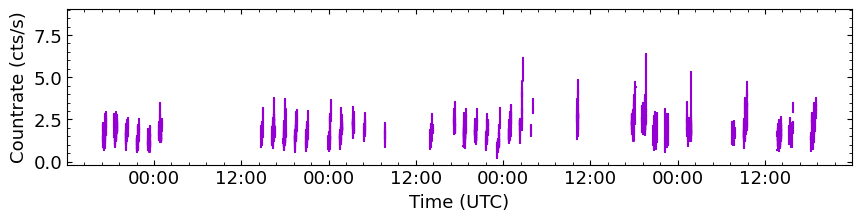

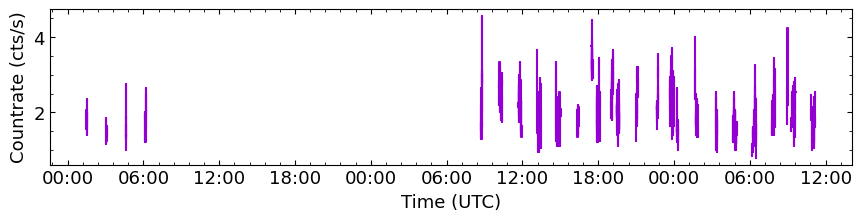

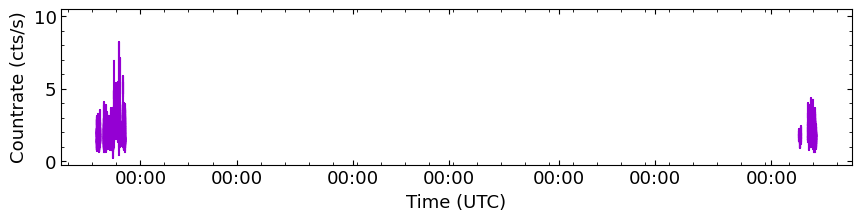

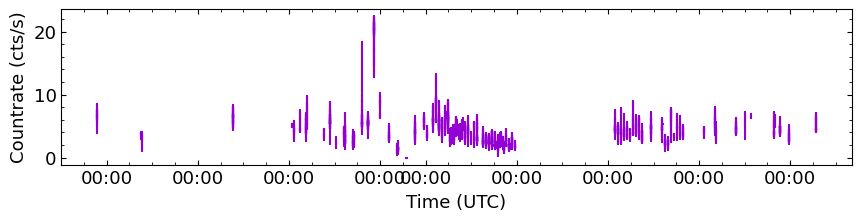

In [29]:
binsize = 20
obs_labels = {'4592010200': '2021a', '4592010300': '2021b', 
              '4592010000': '2021combined', '7656010100': '2024'}

for obs in lightcurves:
    lc = lightcurves[obs]['total'][binsize]
    lc_time = np.asarray(lc.time, dtype=np.float64)
    lc_countrate = np.asarray(lc.countrate, dtype=np.float64)
    
    fig, ax = plt.subplots(figsize=(8.5, 2.1))
    
    gti = np.asarray(lc.gti, dtype=np.float64) if lc.gti is not None else None
    if gti is not None:
        for gti_start, gti_stop in gti:
            mask = (lc_time >= gti_start) & (lc_time <= gti_stop)
            if not np.any(mask):
                continue
            t = Time(lc.mjdref, format='mjd') + TimeDelta(lc_time[mask], format='sec')
            x = t.to_datetime()
            ax.step(x, lc_countrate[mask], where='mid', color='darkviolet', lw=1.5)
    
    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel('Countrate (cts/s)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.savefig(f'{savedir}/nicer_lc_{obs_labels[obs]}.pdf')
    plt.show()

## Z^2 Periodogram

The Z^2_n statistic is a Rayleigh-based test for periodicity in event data. For each trial frequency, event phases are computed and the statistic measures the coherence of the phase distribution. Higher harmonics (n) capture non-sinusoidal pulse shapes. Under the null hypothesis (no pulsation), Z^2_n follows a chi-squared distribution with 2n degrees of freedom.

Observation: 4592010200
FREQUENCY RESULTS:
  Peak:        3.377272527472527e-02 Hz
  Uncertainty: +3.736264e-07 / -3.076923e-07 Hz

PERIOD RESULTS:
  Peak:        2.960969219586128e+01 s
  Uncertainty: +2.697667e-04 / -3.275673e-04 s


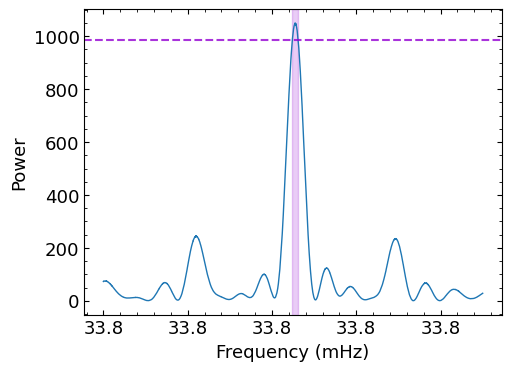

Observation: 4592010300
FREQUENCY RESULTS:
  Peak:        3.377292307692308e-02 Hz
  Uncertainty: +1.373626e-06 / -1.296703e-06 Hz

PERIOD RESULTS:
  Peak:        2.960951877699022e+01 s
  Uncertainty: +1.136894e-03 / -1.204242e-03 s


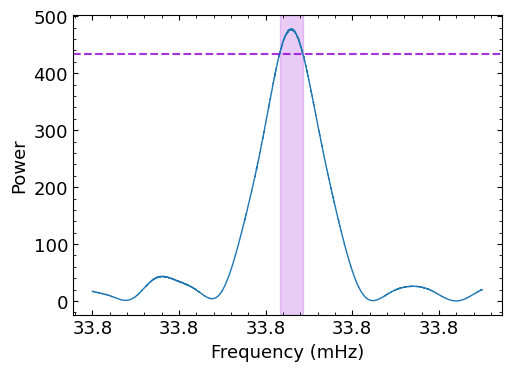

Observation: 4592010000
FREQUENCY RESULTS:
  Peak:        3.377284615384615e-02 Hz
  Uncertainty: +0.000000e+00 / -0.000000e+00 Hz

PERIOD RESULTS:
  Peak:        2.960958621742092e+01 s
  Uncertainty: +0.000000e+00 / -0.000000e+00 s


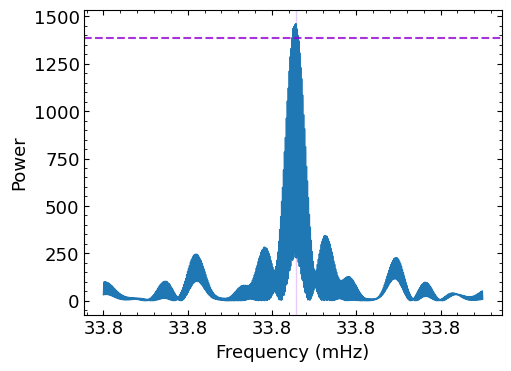

Observation: 7656010100
FREQUENCY RESULTS:
  Peak:        3.377270329670330e-02 Hz
  Uncertainty: +1.428571e-07 / -1.208791e-07 Hz

PERIOD RESULTS:
  Peak:        2.960971146475013e+01 s
  Uncertainty: +1.059793e-04 / -1.252473e-04 s


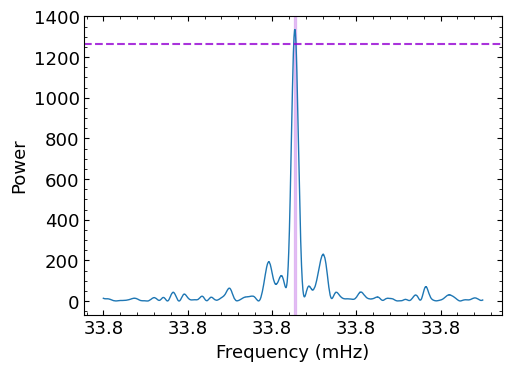

In [68]:
f_min, f_max = 0.033750, 0.033795

frequencies = np.linspace(f_min, f_max, 4096)
nharm = 1

Z2 = {}
obs_names_z2 = {'4592010200': '2021a', '4592010300': '2021b', 
                '4592010000': '2021combined', '7656010100': '2024'}

for obs in lightcurves:
    fig, ax = plt.subplots(figsize=(5, 3.6))
    
    evt = events[obs]['total']
    frequency, power = z_n_search(evt.time, frequencies, nharm=nharm)
    Z2[obs] = (frequency, power)
    
    ax.plot(frequency*1e3, power, lw=1)
    
    peak_freq = frequencies[np.argmax(power)]
    peak_power = power[np.argmax(power)]
    
    print(f"Observation: {obs}")
    freq_min, freq_max, power_min, _ = get_frequency_uncertainty(
        frequencies, power, peak_freq, peak_power, nharm, 1
    )
    
    ax.axvspan(freq_min*1e3, freq_max*1e3, alpha=0.2, color='darkviolet')
    ax.axhline(power_min, alpha=0.8, color='darkviolet', ls='--')
    
    ax.set_xlabel('Frequency (mHz)')
    ax.set_ylabel('Power')
    ax.ticklabel_format(axis='x', useOffset=False)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
    
    fig.savefig(f'{savedir}/nicer_z2_{obs_names_z2[obs]}.pdf')
    plt.show()

## High-Resolution Combined Periodogram

Zoom in on the combined 2021 observation to resolve the sinc-like aliasing pattern.

Combined 2021 observation:
FREQUENCY RESULTS:
  Peak:        3.377273284624344e-02 Hz
  Uncertainty: +1.127940e-08 / -1.253267e-08 Hz

PERIOD RESULTS:
  Peak:        2.960968555765633e+01 s
  Uncertainty: +1.098782e-05 / -9.889027e-06 s
33772.73284624344


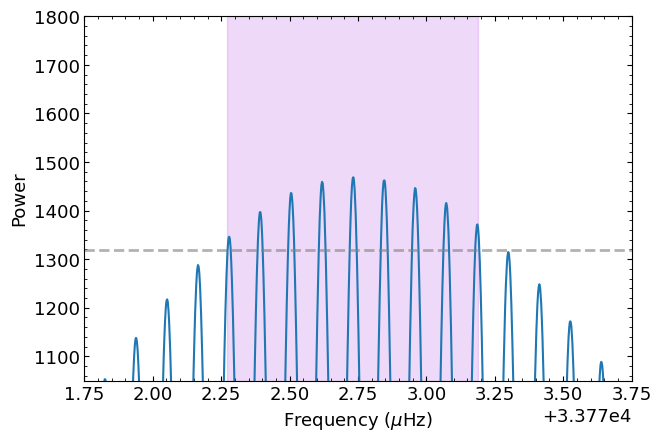

In [63]:
# High-resolution periodogram of combined 2021 data
f_min_zoom, f_max_zoom = 0.03376781252, 0.03377807803
frequencies_hires = np.linspace(f_min_zoom, f_max_zoom, 8192)

fig, ax = plt.subplots(figsize=(6.5, 4.3))

evt = events['4592010000']['total']
frequency_hires, power_hires = z_n_search(evt.time, frequencies_hires, nharm=nharm)
combined_Z2 = (frequency_hires, power_hires)

ax.plot(frequency_hires*1e6, power_hires, lw=1.5)

peak_freq = frequency_hires[np.argmax(power_hires)]
peak_power = power_hires[np.argmax(power_hires)]

print("Combined 2021 observation:")
freq_min, freq_max, power_min, _ = get_frequency_uncertainty(
    frequency_hires, power_hires, peak_freq, peak_power, nharm, 2
)

#ax.axvspan(freq_min*1e6, freq_max*1e6, alpha=0.3, color='darkviolet')
ax.axvspan(33772.27, 33773.19, alpha=0.15, color='darkviolet')
ax.axhline(power_min, alpha=0.6, color='gray', lw=2, ls='--')
#ax.axvline(peak_freq*1e6, alpha=0.15, color='darkviolet', lw=3)
print(peak_freq*1e6)

ax.set_xlim(0.03377175*1e6, 0.03377375*1e6)
ax.set_ylim(1050, 1800)
ax.set_xlabel(r'Frequency ($\mu\text{Hz}$)')
ax.set_ylabel('Power')
ax.ticklabel_format(axis='x', useOffset=True)

#ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f')) 
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useOffset=True)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)

"""from matplotlib.ticker import FuncFormatter

x_0 = 33.77  # Define the zeroth-order offset
n = 4        # Define the scaling exponent to eliminate leading zeros

def format_scaled_residual(x, pos):
    # Calculate the scaled residual L(x)
    residual = (x - x_0) * (10**n)
    
    # Format to 1 decimal place to prevent floating point artifact trailing digits
    return f'{residual:.1f}'

# Apply the mapping function to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(format_scaled_residual))"""

fig.savefig(f'{savedir}/nicer_z2_hires_2021.pdf')
plt.show()

## Folded Profiles

Phase-folding bins events by their arrival phase (modulo the spin period) to build up a pulse profile. The folded lightcurves show source count rates after subtracting the SCORPEON-modeled background. Hardness ratios (HR = (H-S)/(H+S)) trace spectral changes with pulse phase.

In [32]:
ephemeris = 59230
P_orb = 29.60968584
n_bins = 35

# Fold source lightcurves
folded_lightcurves = {}
for obs in ['4592010200', '4592010300', '7656010100']:
    folded_lightcurves[obs] = {}
    for energy in events[obs]:
        folded_lightcurves[obs][energy] = fold(events[obs][energy], P_orb, ephemeris, n_bins)

# Fold background lightcurves
folded_bkg_lightcurves = {}
for obs in bkg_lightcurves:
    folded_bkg_lightcurves[obs] = {}
    for energy in bkg_lightcurves[obs]:
        folded_bkg_lightcurves[obs][energy] = fold_lightcurve(
            bkg_lightcurves[obs][energy], P_orb, ephemeris, n_bins
        )

print(f"Folded at P = {P_orb:.8f} s, epoch MJD {ephemeris}")

Folded at P = 29.60968584 s, epoch MJD 59230


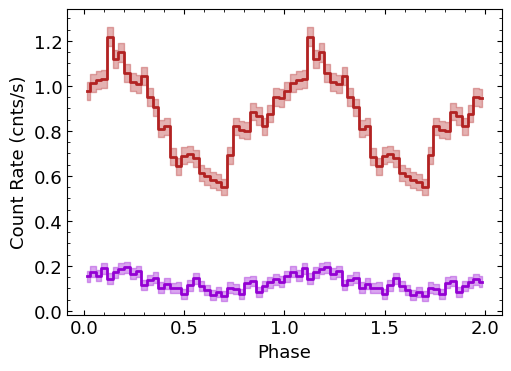

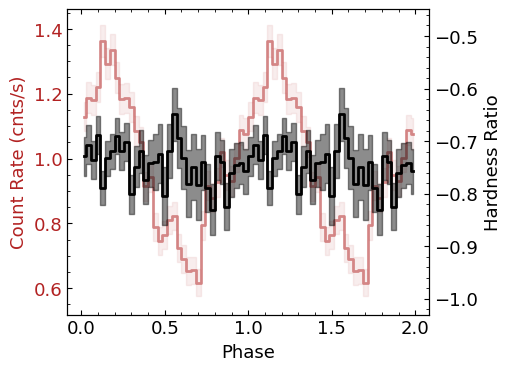

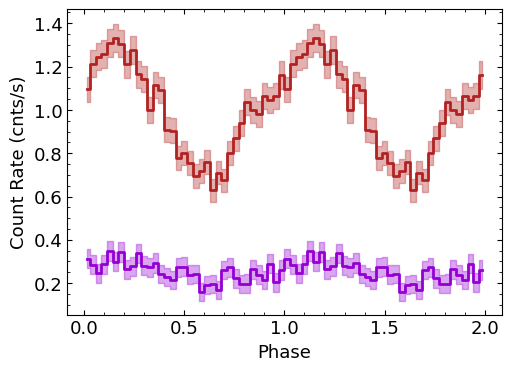

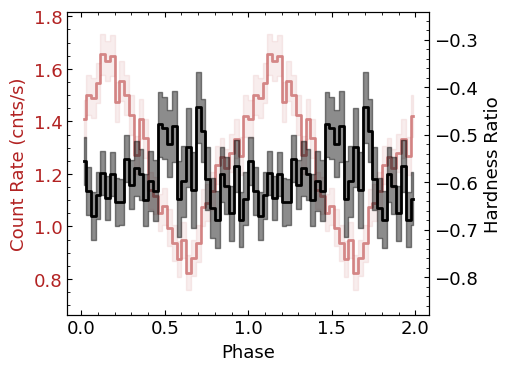

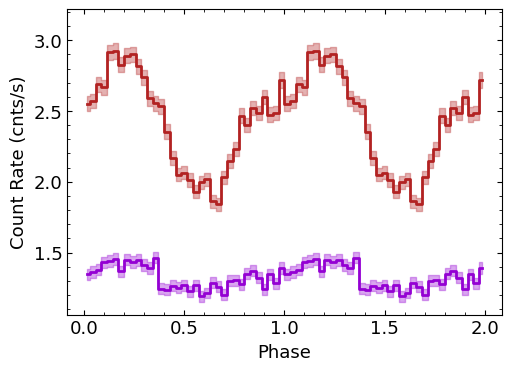

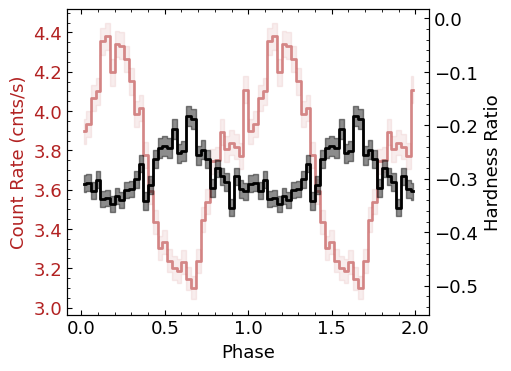

In [33]:
# Plot background-subtracted folded lightcurves with hardness ratios
HR = {}
HR_error = {}

obs_save_names = {'4592010200': '2021a', '4592010300': '2021b', '7656010100': '2024'}

for obs in ['4592010200', '4592010300', '7656010100']:
    HR[obs] = {}
    HR_error[obs] = {}
    
    # Get data
    _, _, soft_cr, soft_err, _ = folded_lightcurves[obs]['soft']
    _, _, soft_bkg_cr, soft_bkg_err, _ = folded_bkg_lightcurves[obs]['soft']
    _, _, hard_cr, hard_err, _ = folded_lightcurves[obs]['hard']
    _, _, hard_bkg_cr, hard_bkg_err, _ = folded_bkg_lightcurves[obs]['hard']
    phase, _, total_cr, total_err, _ = folded_lightcurves[obs]['total']
    
    # Phase centers and extension to [0,2]
    phase_centers = phase[1:] - np.diff(phase) / 2
    ext_phase = np.concatenate([phase_centers, phase_centers + 1])
    
    # Background-subtracted soft and hard
    soft_sub = soft_cr - soft_bkg_cr
    soft_sub_err = np.sqrt(soft_err**2 + soft_bkg_err**2)
    hard_sub = hard_cr - hard_bkg_cr
    hard_sub_err = np.sqrt(hard_err**2 + hard_bkg_err**2)
    
    # --- Plot 1: Soft + Hard separately ---
    fig, ax = plt.subplots(figsize=(5, 3.6))
    
    ext_soft = np.concatenate([soft_sub, soft_sub])
    ext_soft_err = np.concatenate([soft_sub_err, soft_sub_err])
    ext_hard = np.concatenate([hard_sub, hard_sub])
    ext_hard_err = np.concatenate([hard_sub_err, hard_sub_err])
    
    ax.step(ext_phase, ext_soft, where='mid', color='firebrick', lw=2)
    ax.fill_between(ext_phase, ext_soft - ext_soft_err, ext_soft + ext_soft_err,
                    step='mid', color='firebrick', alpha=0.35)
    ax.step(ext_phase, ext_hard, where='mid', color='darkviolet', lw=2)
    ax.fill_between(ext_phase, ext_hard - ext_hard_err, ext_hard + ext_hard_err,
                    step='mid', color='darkviolet', alpha=0.35)
    
    ax.set_ylim(top=1.1*np.max(soft_sub))
    ax.set_xlabel('Phase')
    ax.set_ylabel('Count Rate (cnts/s)')
    
    fig.savefig(f'{savedir}/nicer_folded_softhard_{obs_save_names[obs]}.pdf')
    plt.show()
    
    # --- Plot 2: Total flux + Hardness Ratio (dual axis) ---
    fig, ax = plt.subplots(figsize=(5, 3.6))
    
    total_sub = total_cr - soft_bkg_cr - hard_bkg_cr
    total_sub_err = np.sqrt(total_err**2 + soft_bkg_err**2 + hard_bkg_err**2)
    ext_total = np.concatenate([total_sub, total_sub])
    ext_total_err = np.concatenate([total_sub_err, total_sub_err])
    
    ax.step(ext_phase, ext_total, where='mid', color='firebrick', lw=2, alpha=0.5)
    ax.fill_between(ext_phase, ext_total - ext_total_err, ext_total + ext_total_err,
                    step='mid', color='firebrick', alpha=0.08)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Count Rate (cnts/s)', color='firebrick')
    ax.tick_params(axis='y', labelcolor='firebrick')
    
    # Scale y-range
    rate_min = np.min(total_sub) - 2 * np.max(total_sub_err)
    rate_max = np.max(total_sub) + 2 * np.max(total_sub_err)
    ax.set_ylim(rate_min, rate_max)
    
    # Hardness ratio on right axis
    hr = (hard_sub - soft_sub) / (hard_sub + soft_sub)
    hr_err = (2 * np.sqrt(hard_sub**2 * soft_sub_err**2 + soft_sub**2 * hard_sub_err**2)) / (hard_sub + soft_sub)**2
    HR[obs] = hr
    HR_error[obs] = hr_err
    
    ext_hr = np.concatenate([hr, hr])
    ext_hr_err = np.concatenate([hr_err, hr_err])
    
    ax2 = ax.twinx()
    ax2.step(ext_phase, ext_hr, where='mid', color='black', lw=2)
    ax2.fill_between(ext_phase, ext_hr - ext_hr_err, ext_hr + ext_hr_err,
                     step='mid', color='black', alpha=0.45)
    ax2.set_ylabel('Hardness Ratio')
    
    hr_min = np.min(hr) - 2 * 0.1
    hr_max = np.max(hr) + 2 * 0.1
    ax2.set_ylim(hr_min, hr_max)
    
    fig.savefig(f'{savedir}/nicer_folded_hr_{obs_save_names[obs]}.pdf')
    plt.show()

## Background Folded Profiles

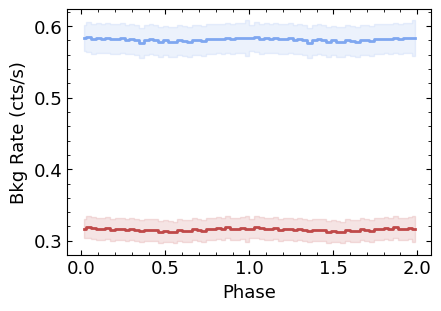

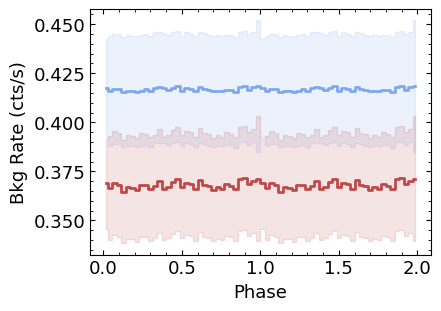

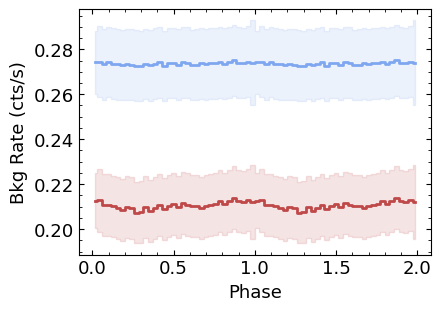

In [34]:
# Plot folded background to verify no pulsations
obs_save_names_bkg = {'4592010200': '2021a', '4592010300': '2021b', '7656010100': '2024'}

for obs in ['4592010200', '4592010300', '7656010100']:
    fig, ax = plt.subplots(figsize=(4.3, 3))
    
    colors = {'soft': 'cornflowerblue', 'hard': 'firebrick'}
    
    for energy in ['soft', 'hard']:
        phase, _, cr, err, _ = folded_bkg_lightcurves[obs][energy]
        phase_centers = phase[1:] - np.diff(phase) / 2
        ext_phase = np.concatenate([phase_centers, phase_centers + 1])
        ext_cr = np.concatenate([cr, cr])
        ext_err = np.concatenate([err, err])
        
        ax.step(ext_phase, ext_cr, where='mid', color=colors[energy], lw=2, alpha=0.8)
        ax.fill_between(ext_phase, ext_cr - ext_err, ext_cr + ext_err,
                        step='mid', color=colors[energy], alpha=0.12)
    
    ax.set_xlabel('Phase')
    ax.set_ylabel('Bkg Rate (cts/s)')
    
    fig.savefig(f'{savedir}/nicer_bkg_folded_{obs_save_names_bkg[obs]}.pdf')
    plt.show()

## Statistical Tests

### F-test for Hardness Ratio Variability

We test whether the hardness ratio varies sinusoidally with pulse phase, comparing two models:
- **Null hypothesis (H0)**: HR is constant across all phase bins (1 free parameter: mean HR)
- **Alternative hypothesis (H1)**: HR follows a sinusoid (3 free parameters: offset, amplitude, phase)

The F-statistic compares the improvement in chi-squared per additional degree of freedom. A significant F-test (p < 0.05) indicates the spectrum genuinely softens or hardens with pulse phase.

### Phase Correlation Test

If the hardness ratio does vary, we determine whether it is **correlated** or **anticorrelated** with flux:
- **Anticorrelation** (HR maximum at flux minimum): The source is spectrally harder when fainter. This can indicate absorption by intervening material (e.g., accretion curtain) or geometric effects where harder emission regions are occulted.
- **Correlation** (HR maximum at flux maximum): The source is harder when brighter, possibly indicating a harder emission mechanism dominating at peak.

In [35]:
# F-test for hardness ratio variability
observations = ['4592010200', '4592010300', '7656010100']
obs_names = ['2021A', '2021B', '2024']

print("F-TEST FOR HARDNESS RATIO VARIABILITY\n")

for obs, obs_name in zip(observations, obs_names):
    print(f"OBSERVATION: {obs_name}")
    result = test_hardness_ratio_variability(HR[obs], HR_error[obs])
    print()

F-TEST FOR HARDNESS RATIO VARIABILITY

OBSERVATION: 2021A

Model 1 (Constant): chi2 = 27.85, dof = 34, chi2_red = 0.82
Model 2 (Sinusoid): chi2 = 25.40, dof = 32, chi2_red = 0.79
  Offset: -0.7440 +/- 0.0077
  Amplitude: 0.0162 +/- 0.0104
  Phase shift: -0.006 cycles

F-test: F = 1.54, p = 2.29e-01, 1.2 sigma
Result: No significant improvement

OBSERVATION: 2021B

Model 1 (Constant): chi2 = 31.99, dof = 34, chi2_red = 0.94
Model 2 (Sinusoid): chi2 = 24.65, dof = 32, chi2_red = 0.77
  Offset: -0.5904 +/- 0.0102
  Amplitude: 0.0392 +/- 0.0145
  Phase shift: -0.300 cycles

F-test: F = 4.76, p = 1.54e-02, 2.4 sigma
Result: Sinusoid better (p < 0.05)

OBSERVATION: 2024

Model 1 (Constant): chi2 = 232.61, dof = 34, chi2_red = 6.84
Model 2 (Sinusoid): chi2 = 79.68, dof = 32, chi2_red = 2.49
  Offset: -0.2901 +/- 0.0028
  Amplitude: -0.0497 +/- 0.0040
  Phase shift: 0.135 cycles

F-test: F = 30.71, p = 3.60e-08, 5.5 sigma
Result: Sinusoid significantly better (p < 0.001)



In [36]:
# Phase correlation test: HR vs Flux
print("PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX\n")

for obs, obs_name in zip(observations, obs_names):
    print(f"OBSERVATION: {obs_name}")
    _, _, flux_data, flux_errors, _ = folded_lightcurves[obs]['total']
    result = test_phase_correlation(flux_data, flux_errors, HR[obs], HR_error[obs])
    print()

PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX

OBSERVATION: 2021A

HR amplitude: 0.0162 +/- 0.0104 (1.6 sigma)
Flux amplitude: 0.2840 +/- 0.0089 (32.1 sigma)

Flux max at phase: 0.131 +/- 0.0050
HR max at phase: 0.256 +/- 0.1054
Phase difference: 0.125 +/- 0.1055 cycles

Deviation from in-phase (delta_phi=0): 1.2 sigma
Deviation from anticorr (|delta_phi|=0.5): 3.6 sigma
Result: IN PHASE - HR max aligns with flux max

OBSERVATION: 2021B

HR amplitude: 0.0392 +/- 0.0145 (2.7 sigma)
Flux amplitude: 0.3256 +/- 0.0148 (22.1 sigma)

Flux max at phase: 0.132 +/- 0.0073
HR max at phase: 0.550 +/- 0.0561
Phase difference: 0.417 +/- 0.0565 cycles

Deviation from in-phase (delta_phi=0): 7.4 sigma
Deviation from anticorr (|delta_phi|=0.5): 1.5 sigma
Result: ANTICORRELATED - HR max aligns with flux min

OBSERVATION: 2024

HR amplitude: 0.0497 +/- 0.0040 (12.4 sigma)
Flux amplitude: 0.5222 +/- 0.0145 (36.1 sigma)

Flux max at phase: 0.128 +/- 0.0044
HR max at phase: 0.615 +/- 0.0125
Phase differen